In [618]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
%matplotlib inline
from sklearn import tree
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix#for visualizing tree
from sklearn import svm
import datetime
warnings.filterwarnings("ignore")

**Loading Data**

In [619]:
data = pd.read_csv("C:/Users/rakray/Documents/Deloitte_Training/Code/deloitte-training-project-1/datasets/application_data.csv")
df_application_data = pd.DataFrame(data)
data = pd.read_csv("C:/Users/rakray/Documents/Deloitte_Training/Code/deloitte-training-project-1/datasets/previous_application.csv")
df_previous_application = pd.DataFrame(data)

In [620]:
df_application_data["ad_target_ct"].value_counts()

0    282686
1     24825
Name: ad_target_ct, dtype: int64

**Missing value removal**

In [621]:
acceptable_non_NAN_values_fraction = 0.5
df_application_data_2 = df_application_data.dropna(axis='columns', how="any", thresh=(1-acceptable_non_NAN_values_fraction)*len(df_application_data.index))
df_previous_application_2 = df_previous_application.dropna(axis='columns', how="any", thresh=(1-acceptable_non_NAN_values_fraction)*len(df_previous_application.index))

In [622]:
df_application_data_2["ad_target_ct"].value_counts()

0    282686
1     24825
Name: ad_target_ct, dtype: int64

**NAN value replacement**

In [623]:
def NAN_value_replacement(dataframe):
    for col in dataframe:
        if (dataframe[col].dtype == "int64" or dataframe[col].dtype == "float64"):
            dataframe[col] = dataframe[col].fillna(dataframe[col].median())
        elif (dataframe[col].dtype == "object"):
            dataframe[col] = dataframe[col].fillna(dataframe[col].mode().iloc[0])
    return dataframe

df_application_data_2 = NAN_value_replacement(df_application_data_2)
df_previous_application_2 = NAN_value_replacement(df_previous_application_2)

In [624]:
df_application_data_2["ad_target_ct"].value_counts()

0    282686
1     24825
Name: ad_target_ct, dtype: int64

**Boxplot**

In [625]:
def Boxplot(dataframe, column):
    plt.figure(figsize=(10,7))
    plt.title(column)
    plt.boxplot(dataframe[column])
    plt.show()

**Numerical Dataframe**

In [626]:
def numerical_df(df):
    numerical = df.select_dtypes(exclude='object')
    return numerical
# gettting numerical dfs
numerical_df_previous_application = numerical_df(df_previous_application_2)
numerical_df_application_data = numerical_df(df_application_data_2)

In [627]:
df_application_data_2["ad_target_ct"].value_counts()

0    282686
1     24825
Name: ad_target_ct, dtype: int64

**Removing outliers**

In [628]:
# Outlier removing function
def new_IQR(res_df, numerical_df):
    for i in list(numerical_df):
        sorted(i)
        iqr1 = res_df[i].quantile(0.25)
        iqr3 = res_df[i].quantile(0.75)
        iqr = iqr3-iqr1
        lower_limit = iqr1 - 1.5*iqr
        upper_limit = iqr3 + 1.5*iqr
        temp_data = res_df[(res_df[i] > lower_limit) & (res_df[i] <upper_limit)]
#         print(temp_data)
#         print((res_df[i] > lower_limit) & (res_df[i] <upper_limit))
        if temp_data[i].value_counts().shape[0] > 10:
            res_df = res_df[(res_df[i] > lower_limit) & (res_df[i] <upper_limit)]
#             print(res_df)
    return res_df

In [629]:
# Removing outliers
df_previous_application_2 = new_IQR(df_previous_application_2, numerical_df_previous_application)
df_application_data_2 = new_IQR(df_application_data_2, numerical_df_application_data)

In [630]:
df_application_data_2["ad_target_ct"].value_counts()

0    96712
1    11149
Name: ad_target_ct, dtype: int64

**Categorical data**

In [631]:
# categorical
df_previous_application_2["ad_MONTHS_decision_ct"] = abs(df_previous_application_2["ad_days_decision_ct"])/30
bins = [0,1,2,3,4,5,6,7,8,9,np.inf]
slots = ["0-1","1-2","2-3","3-4","4-5","5-6","6-7","7-8","8-9","Above 9"]
df_previous_application_2["ad_MONTHS_decision_ct"] = pd.cut(df_previous_application_2["ad_MONTHS_decision_ct"], bins=bins, labels=slots)

df_application_data_2["ad_YEARS_birth_ct"] = abs(df_application_data_2["ad_days_birth_ct"])/365
bins = [0,10,20,30,40,50,60,70,80,90,np.inf]
slots = ["0-10","11-20","21-30","31-40","41-50","51-60","61-70","71-80","81-90","Above 90"]
df_application_data_2["ad_YEARS_birth_ct"] = pd.cut(df_application_data_2["ad_YEARS_birth_ct"], bins=bins, labels=slots)

In [632]:
df_application_data_2["ad_target_ct"].value_counts()

0    96712
1    11149
Name: ad_target_ct, dtype: int64

**Encoding**

In [633]:
# Encoding
def encoder(dataframe):
    label_encoder = preprocessing.LabelEncoder()
    for (columnName, columnData) in dataframe.iteritems():
        if columnData.dtypes == "object" or columnData.dtype.name == "category":
            # print(dataframe[columnName].dtypes)
            dataframe[columnName] = label_encoder.fit_transform(dataframe[columnName])
    return dataframe

df_previous_application_2 = encoder(df_previous_application_2)
df_application_data_2 = encoder(df_application_data_2)

In [634]:
df_application_data_2["ad_target_ct"].value_counts()

0    96712
1    11149
Name: ad_target_ct, dtype: int64

**Feature Selection**

In [635]:
# Feature Selection - Correleation Coefficient
def corr_co(name, dataframe, thresh, plot_visibility):
    corr_matrix = dataframe.corr()
    if (plot_visibility):
        sns.heatmap(corr_matrix,annot=True,cmap=plt.cm.CMRmap_r)
        plt.show()

    coll_corr = []
    threshold = thresh

    flag = 0

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                if colname not in coll_corr and flag > 0:
                    coll_corr.append(colname)
                    # print(colname)
                flag+=1
    # print ("\n\n")
    return coll_corr

# calling correlation coefficient function
corr_matrix_previous_application = corr_co("previous_application.csv", df_previous_application_2, 0.85, False)
corr_matrix_application_data = corr_co("current_application", df_application_data_2, 0.85, False)

In [636]:
# drop the columns obtained from coefficient function
df_previous_application_2_dropped = df_previous_application_2.drop(labels=corr_matrix_previous_application, inplace=False, axis=1)
df_application_data_2_dropped = df_application_data_2.drop(labels=corr_matrix_application_data, inplace=False, axis=1)

In [637]:
df_application_data_2["ad_target_ct"].value_counts()

0    96712
1    11149
Name: ad_target_ct, dtype: int64

In [638]:
df_application_data_2_dropped["ad_target_ct"].value_counts()

0    96712
1    11149
Name: ad_target_ct, dtype: int64

**Merge**

In [639]:
# merge
merged_dataframe = pd.merge(df_application_data_2, df_previous_application_2, how='inner', on='ad_sk_id_curr_ct')
today = datetime.datetime.today().strftime('%d-%m-%Y')
merged_dataframe.to_csv(f'raktim-cleaned-data-{today}.csv')

In [651]:
# merged_dataframe.dtypes
merged_dataframe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114311 entries, 0 to 114310
Data columns (total 115 columns):
 #    Column                              Dtype  
---   ------                              -----  
 0    ad_sk_id_curr_ct                    int64  
 1    ad_target_ct                        int64  
 2    ad_name_contract_type_ct_x          int32  
 3    ad_code_gender_ct                   int32  
 4    ad_flag_own_car_ct                  int32  
 5    ad_flag_own_realty_ct               int32  
 6    ad_cnt_children_ct                  int64  
 7    ad_amt_income_total_ct              float64
 8    ad_amt_credit_ct_x                  float64
 9    ad_amt_annuity_ct_x                 float64
 10   ad_amt_goods_price_ct_x             float64
 11   ad_name_type_suite_ct_x             int32  
 12   ad_name_income_type_ct              int32  
 13   ad_name_education_type_ct           int32  
 14   ad_name_family_status_ct            int32  
 15   ad_name_housing_type_ct         

**Univariate**

In [648]:
# sample
def data_type(dataset,col):
    if dataset[col].dtype == np.int64 or dataset[col].dtype == np.float64 or dataset[col].dtype == np.int32:
        return "numerical"
    if dataset[col].dtype == "object":
        return "categorical"

def univariate(dataset,col,target_col,ylog=False,x_label_angle=False,h_layout=True):
    if data_type(dataset,col) == "numerical":
        sns.distplot(dataset[col],hist=False)
        
        
    elif data_type(dataset,col) == "categorical":
        val_count = dataset[col].value_counts()
        df1 = pd.DataFrame({col: val_count.index,'count': val_count.values})
        
        
        target_1_percentage = dataset[[col, target_col]].groupby([col],as_index=False).mean()
        target_1_percentage[target_col] = target_1_percentage[target_col]*100
        target_1_percentage.sort_values(by=target_col,inplace = True)

# If the plot is not readable, use the log scale

        if(h_layout):
            fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))
        else:
            fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(25,35))
              
        
# 1. Subplot 1: Count plot of the column
        
        s = sns.countplot(ax=ax1, x=col, data=dataset, hue=target_col)
        ax1.set_title(col, fontsize = 20)
        ax1.legend(['Repayer','Defaulter'])
        ax1.set_xlabel(col,fontdict={'fontsize' : 15, 'fontweight' : 3})
        
        if(x_label_angle):
            s.set_xticklabels(s.get_xticklabels(),rotation=75)
        
# 2. Subplot 2: Percentage of defaulters within the column
        
        s = sns.barplot(ax=ax2, x = col, y=target_col, data=target_1_percentage)
        ax2.set_title("Defaulters % in "+col, fontsize = 20)    
        ax2.set_xlabel(col,fontdict={'fontsize' : 15, 'fontweight' : 3})
        ax2.set_ylabel(target_col,fontdict={'fontsize' : 15, 'fontweight' : 3})
        
        if(x_label_angle):
            s.set_xticklabels(s.get_xticklabels(),rotation=75)
            
            
# If the plot is not readable, use the log scale
                
        if ylog:
            ax1.set_yscale('log')
            ax1.set_ylabel("Count (log)",fontdict={'fontsize' : 15, 'fontweight' : 3})
        else:
            ax1.set_ylabel("Count",fontdict={'fontsize' : 15, 'fontweight' : 3})

        
        plt.show()

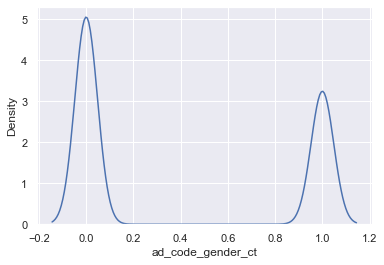

In [649]:
# Univariate call
univariate(df_application_data_2_dropped, "ad_code_gender_ct", "ad_target_ct")

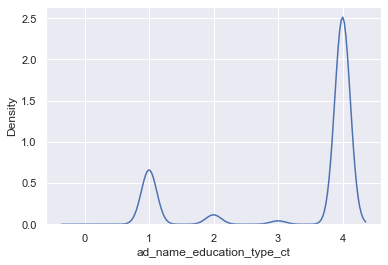

In [650]:
univariate(df_application_data_2_dropped, "ad_name_education_type_ct", "ad_target_ct")

**Insights**


Insight dataframe - 1: Education Type

    ad_sk_id_curr_ct  ad_target_ct  ad_name_education_type_ct
2             100004             0                          4
3             100006             0                          4
4             100007             0                          4
5             100008             0                          4
10            100014             0                          1


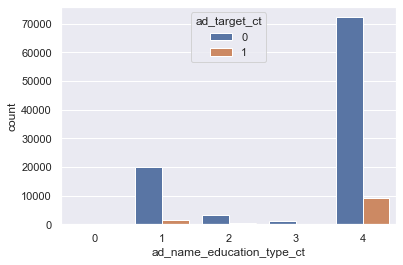

In [642]:
# Insight dataframe 1
insight_df_1 = df_application_data_2[["ad_sk_id_curr_ct", "ad_target_ct", "ad_name_education_type_ct"]]
print("\nInsight dataframe - 1: Education Type\n")
print(insight_df_1.head())
col = 'ad_name_education_type_ct'
target_col = 'ad_target_ct'
sns.set()
s = sns.countplot(insight_df_1[col],hue=insight_df_1[target_col])


Insight dataframe - 2: Housing Type

    ad_sk_id_curr_ct  ad_target_ct  ad_name_housing_type_ct
2             100004             0                        1
3             100006             0                        1
4             100007             0                        1
5             100008             0                        1
10            100014             0                        1


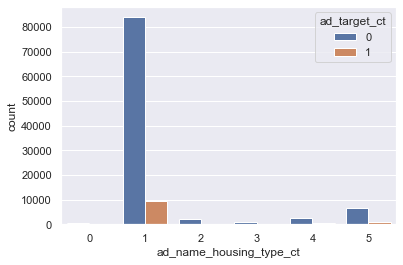

In [643]:
# Insight dataframe 2
insight_df_2 = df_application_data_2[["ad_sk_id_curr_ct", "ad_target_ct", "ad_name_housing_type_ct"]]
print("\nInsight dataframe - 2: Housing Type\n")
print(insight_df_2.head())
col = 'ad_name_housing_type_ct'
target_col = 'ad_target_ct'
sns.set()
s = sns.countplot(insight_df_2[col],hue=insight_df_2[target_col])


Insight dataframe - 3: Occupation Type

    ad_sk_id_curr_ct  ad_target_ct  ad_occupation_type_ct
2             100004             0                      8
3             100006             0                      8
4             100007             0                      3
5             100008             0                      8
10            100014             0                      3


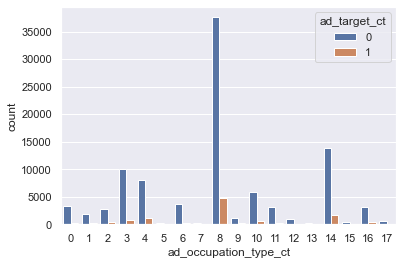

In [644]:
# Insight dataframe 3
insight_df_3 = df_application_data_2[["ad_sk_id_curr_ct", "ad_target_ct", "ad_occupation_type_ct"]]
print("\nInsight dataframe - 3: Occupation Type\n")
print(insight_df_3.head())
col = 'ad_occupation_type_ct'
target_col = 'ad_target_ct'
sns.set()
s = sns.countplot(insight_df_3[col],hue=insight_df_3[target_col])